# Object Detection

В работе использован датасет: https://www.kaggle.com/datasets/tapakah68/yandextoloka-water-meters-dataset/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model

import cv2
import json
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()


plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
DATA_PATH = Path('./data/WaterMeters/')
MODEL_PATH = './models/water_meters_best.h5'

BATCH_SIZE = 8
IMAGE_SIZE = 128

## Загрузка и подготовка данных

In [3]:
data = pd.read_csv(DATA_PATH / 'data.csv')
images_path = DATA_PATH / 'images'

data.sample(5)

,photo_name,value,location
351,id_154_value_498_982.jpg,498.982,"{'type': 'polygon', 'data': [{'x': 0.21159, 'y..."
1162,id_404_value_231_743.jpg,231.743,"{'type': 'polygon', 'data': [{'x': 0.89145, 'y..."
304,id_687_value_71_007.jpg,71.007,"{'type': 'polygon', 'data': [{'x': 0.33465, 'y..."
1135,id_1190_value_197_546.jpg,197.546,"{'type': 'polygon', 'data': [{'x': 0.27268, 'y..."
931,id_1191_value_499_494.jpg,499.494,"{'type': 'polygon', 'data': [{'x': 0.27167, 'y..."


In [4]:
def check_photo_exists(filename):
    path = images_path / filename
    return path.exists()

In [5]:
data_len = len(data)
data = data[data['photo_name'].apply(check_photo_exists)]
print(f'{len(data)} of {data_len} images found in catalog!')

1244 of 1244 images found in catalog!


In [6]:
def preprocess(img):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = preprocess_input(img)
    return img

In [7]:
def read_img(path, prep=True):
    path = str(images_path / path)
    img = cv2.imread(path)
    img = img.astype('float32')
    if prep:
        img = preprocess(img)

    return img

In [8]:
def read_location(location):
    location = location.replace("'", '"')
    location = json.loads(location)['data']

    x1, x2, y1, y2 = 1.0, 0.0, 1.0, 0.0
    for point in location:
        x1 = min(x1, float(point['x']))
        x2 = max(x2, float(point['x']))
        y1 = min(y1, float(point['y']))
        y2 = max(y2, float(point['y']))
    
    return x1, y1, x2, y2

In [9]:
def draw_rect(img, x1, y1, x2, y2):
    x1 = int(x1 * img.shape[1])
    y1 = int(y1 * img.shape[0])
    x2 = int(x2 * img.shape[1])
    y2 = int(y2 * img.shape[0])
    img = cv2.rectangle(img, (x1, y1), (x2, y2),
                        color=(255, 0, 0),
                        thickness=2)
    return img.astype('float32')

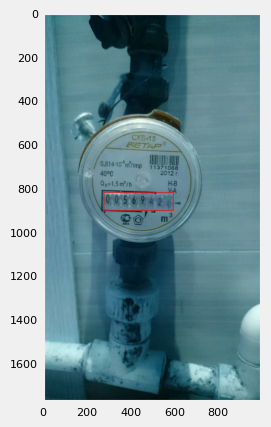

In [10]:
idx = 32
img = read_img(data['photo_name'][idx], False)
loc = read_location(data['location'][idx])
img = draw_rect(img, *loc)
plt.imshow(img / 255.0)
plt.grid(False)
plt.show()

In [11]:
X = np.array(data['photo_name'].progress_apply(read_img).to_list())
y = np.array(data['location'].progress_apply(read_location).to_list())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  0%|          | 0/1244 [00:00<?, ?it/s]

  0%|          | 0/1244 [00:00<?, ?it/s]

## Разработка модели

In [12]:
mobile_net = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

for layer in mobile_net.layers:
    layer.trainable = True #False

x = mobile_net.layers[-1].output
x = Conv2D(4, kernel_size=4, name='coords')(x)
x = Reshape((4,))(x)

model = Model(inputs=mobile_net.inputs, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 8, 8, 512)         262144    
                                                                 
 conv_pw_9

In [13]:
def IoU(y_true, y_pred):
    unions = 0.0
    intersections = 0.0

    diff_width = tf.math.minimum(y_true[:, 0] + y_true[:, 2], y_pred[:, 0] + y_pred[:, 2])
    diff_width -= tf.math.maximum(y_true[:, 0], y_pred[:, 0])

    diff_height = tf.math.minimum(y_true[:,1] + y_true[:,3], y_pred[:,1] + y_pred[:,3])
    diff_height -= tf.math.maximum(y_true[:,1], y_pred[:,1])

    intersection = diff_width * diff_height

    # Compute union
    area_true = y_true[:,2] * y_true[:,3]
    area_pred = y_pred[:,2] * y_pred[:,3]
    union = area_true + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j in range(len(union)):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use 1e-8 to prevent division by zero
    iou = K.round(10000 * intersections / (unions + 1e-8)) / 10000
    return iou

## Обучение модели

In [14]:
model.compile(optimizer="Adam", loss="mse", metrics=[IoU])

callbacks = [
    EarlyStopping(monitor='val_IoU', patience=30, mode="max"),
    ReduceLROnPlateau(monitor='val_IoU',
                      factor=0.2,
                      patience=10,
                      min_lr=1e-7,
                      verbose=1,
                      mode="max"),
    ModelCheckpoint(MODEL_PATH,
                    monitor='val_IoU',
                    save_best_only=True,
                    mode='max')
]

In [15]:
history = model.fit(X_train, y_train,
                    epochs=300,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Epoch 1/300
125/125 [==============================] - 6s 19ms/step - loss: 6.9515 - IoU: 0.0939 - val_loss: 6.0406 - val_IoU: 0.0628 - lr: 0.0010
Epoch 2/300
125/125 [==============================] - 2s 17ms/step - loss: 0.8091 - IoU: 0.1465 - val_loss: 0.8791 - val_IoU: 0.1743 - lr: 0.0010
Epoch 3/300
125/125 [==============================] - 2s 15ms/step - loss: 0.2403 - IoU: 0.1769 - val_loss: 0.2591 - val_IoU: 0.1121 - lr: 0.0010
Epoch 4/300
125/125 [==============================] - 2s 17ms/step - loss: 0.1079 - IoU: 0.2300 - val_loss: 0.1169 - val_IoU: 0.1960 - lr: 0.0010
Epoch 5/300
125/125 [==============================] - 2s 17ms/step - loss: 0.0724 - IoU: 0.2611 - val_loss: 0.0804 - val_IoU: 0.2364 - lr: 0.0010
Epoch 6/300
125/125 [==============================] - 2s 17ms/step - loss: 0.0538 - IoU: 0.2898 - val_loss: 0.0542 - val_IoU: 0.2475 - lr: 0.0010
Epoch 7/300
125/125 [==============================] - 2s 16ms/step - loss: 0.0367 - IoU: 0.3372 - val_loss: 0.0605 - 

125/125 [==============================] - 2s 16ms/step - loss: 0.0020 - IoU: 0.7395 - val_loss: 0.0041 - val_IoU: 0.6600 - lr: 0.0010
Epoch 57/300
125/125 [==============================] - 2s 18ms/step - loss: 0.0015 - IoU: 0.7727 - val_loss: 0.0034 - val_IoU: 0.7106 - lr: 0.0010
Epoch 58/300
125/125 [==============================] - 2s 16ms/step - loss: 0.0015 - IoU: 0.7717 - val_loss: 0.0039 - val_IoU: 0.6988 - lr: 0.0010
Epoch 59/300
125/125 [==============================] - 2s 16ms/step - loss: 0.0015 - IoU: 0.7721 - val_loss: 0.0037 - val_IoU: 0.6892 - lr: 0.0010
Epoch 60/300
125/125 [==============================] - 2s 18ms/step - loss: 0.0013 - IoU: 0.7918 - val_loss: 0.0031 - val_IoU: 0.7114 - lr: 0.0010
Epoch 61/300
125/125 [==============================] - 2s 18ms/step - loss: 0.0014 - IoU: 0.7849 - val_loss: 0.0034 - val_IoU: 0.7200 - lr: 0.0010
Epoch 62/300
125/125 [==============================] - 2s 16ms/step - loss: 0.0012 - IoU: 0.7945 - val_loss: 0.0036 - val_Io

125/125 [==============================] - 2s 17ms/step - loss: 3.5339e-04 - IoU: 0.8918 - val_loss: 0.0015 - val_IoU: 0.8075 - lr: 0.0010
Epoch 111/300
125/125 [==============================] - 2s 16ms/step - loss: 3.4044e-04 - IoU: 0.8899 - val_loss: 0.0019 - val_IoU: 0.7766 - lr: 0.0010
Epoch 112/300
125/125 [==============================] - 2s 16ms/step - loss: 3.2952e-04 - IoU: 0.8895 - val_loss: 0.0014 - val_IoU: 0.8157 - lr: 0.0010
Epoch 113/300
125/125 [==============================] - 2s 17ms/step - loss: 2.8825e-04 - IoU: 0.8989 - val_loss: 0.0015 - val_IoU: 0.8082 - lr: 0.0010
Epoch 114/300
123/125 [============================>.] - ETA: 0s - loss: 2.3362e-04 - IoU: 0.9049
Epoch 114: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
125/125 [==============================] - 2s 17ms/step - loss: 2.3275e-04 - IoU: 0.9051 - val_loss: 0.0014 - val_IoU: 0.8201 - lr: 0.0010
Epoch 115/300
125/125 [==============================] - 2s 18ms/step - loss: 1.5677e-

125/125 [==============================] - 2s 16ms/step - loss: 2.7520e-05 - IoU: 0.9678 - val_loss: 0.0012 - val_IoU: 0.8418 - lr: 8.0000e-06
Epoch 160/300
125/125 [==============================] - 2s 17ms/step - loss: 2.7371e-05 - IoU: 0.9672 - val_loss: 0.0012 - val_IoU: 0.8417 - lr: 8.0000e-06
Epoch 161/300
125/125 [==============================] - 2s 16ms/step - loss: 2.6349e-05 - IoU: 0.9678 - val_loss: 0.0012 - val_IoU: 0.8418 - lr: 8.0000e-06
Epoch 162/300
125/125 [==============================] - 4s 30ms/step - loss: 2.6851e-05 - IoU: 0.9680 - val_loss: 0.0012 - val_IoU: 0.8423 - lr: 8.0000e-06
Epoch 163/300
125/125 [==============================] - 2s 18ms/step - loss: 2.8256e-05 - IoU: 0.9670 - val_loss: 0.0012 - val_IoU: 0.8422 - lr: 8.0000e-06
Epoch 164/300
125/125 [==============================] - 2s 16ms/step - loss: 2.6127e-05 - IoU: 0.9687 - val_loss: 0.0012 - val_IoU: 0.8422 - lr: 8.0000e-06
Epoch 165/300
125/125 [==============================] - 2s 16ms/step - 

125/125 [==============================] - 2s 16ms/step - loss: 2.1607e-05 - IoU: 0.9708 - val_loss: 0.0012 - val_IoU: 0.8427 - lr: 3.2000e-07
Epoch 210/300
125/125 [==============================] - ETA: 0s - loss: 2.2969e-05 - IoU: 0.9702
Epoch 210: ReduceLROnPlateau reducing learning rate to 1e-07.
125/125 [==============================] - 2s 16ms/step - loss: 2.2969e-05 - IoU: 0.9702 - val_loss: 0.0012 - val_IoU: 0.8427 - lr: 3.2000e-07
Epoch 211/300
125/125 [==============================] - 2s 16ms/step - loss: 2.1383e-05 - IoU: 0.9713 - val_loss: 0.0012 - val_IoU: 0.8430 - lr: 1.0000e-07
Epoch 212/300
125/125 [==============================] - 2s 16ms/step - loss: 2.2889e-05 - IoU: 0.9701 - val_loss: 0.0012 - val_IoU: 0.8430 - lr: 1.0000e-07
Epoch 213/300
125/125 [==============================] - 2s 17ms/step - loss: 2.2711e-05 - IoU: 0.9710 - val_loss: 0.0012 - val_IoU: 0.8429 - lr: 1.0000e-07
Epoch 214/300
125/125 [==============================] - 2s 17ms/step - loss: 2.165

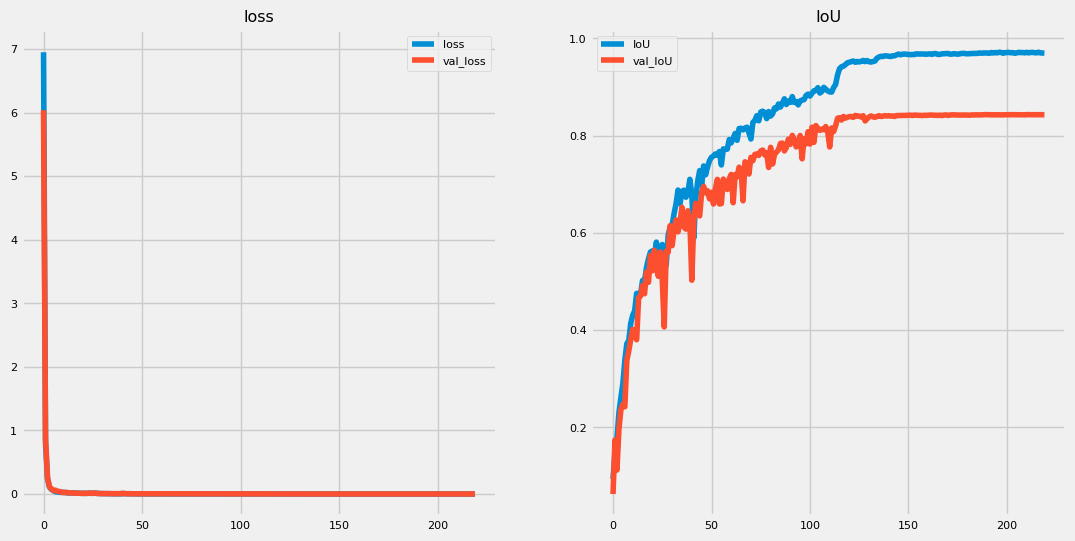

In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    for i, key in enumerate(['loss', 'IoU']):
        plt.subplot(1, 2, i+1)
        plt.plot(history[key], label=key)
        plt.plot(history['val_'+key], label='val_'+key)
        plt.title(key)
        plt.grid(True)
        plt.legend()

    plt.show()

plot_history(history.history)

## Результат работы модели

In [17]:
best_model = load_model(MODEL_PATH, custom_objects={'IoU': IoU})
test_ids = np.random.randint(0, data.shape[0], size=9)
test_imgs = data['photo_name'][test_ids]

imgs = test_imgs.apply(read_img).to_list()
imgs_pred = best_model.predict(np.array(imgs))

1/1 [==============================] - 0s 211ms/step


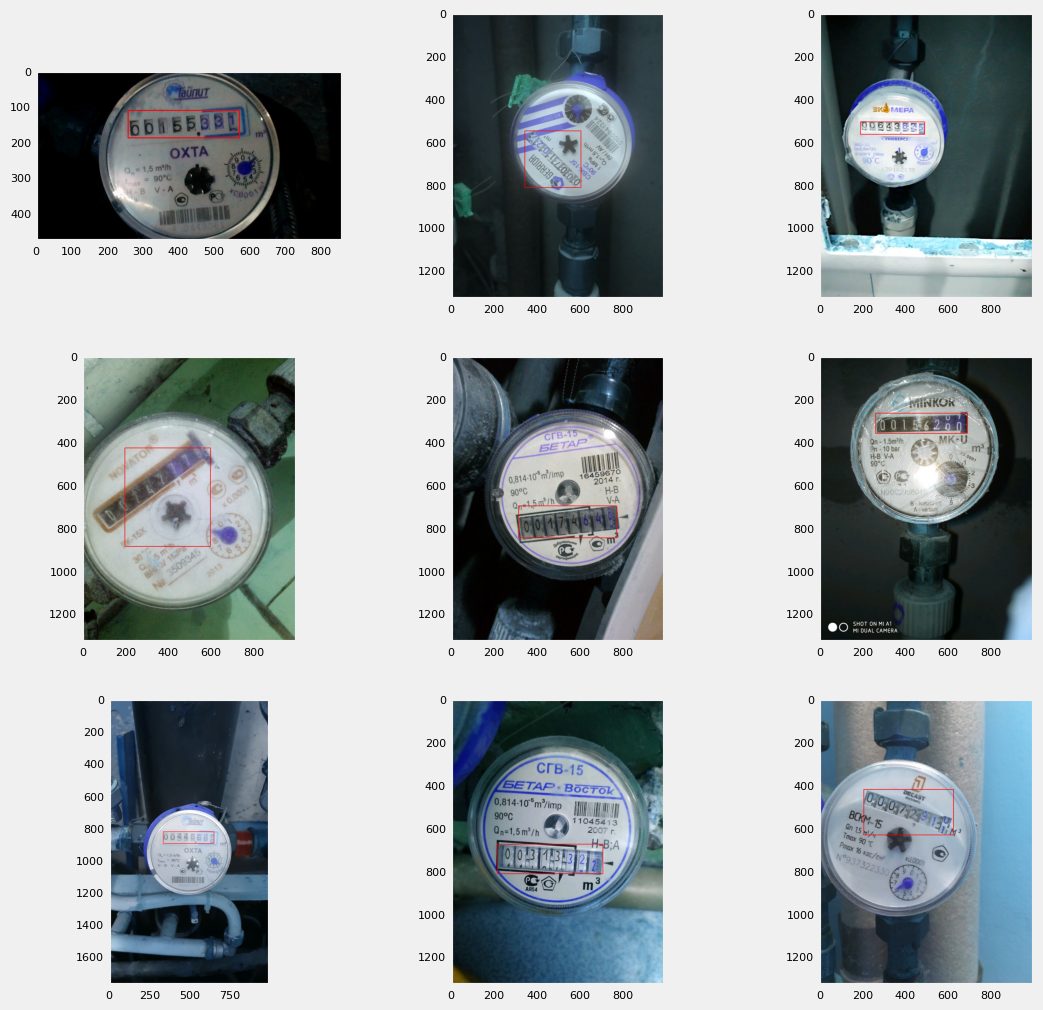

In [18]:
plt.figure(figsize=(12, 12))

for i, (img_path, loc) in enumerate(zip(test_imgs.values, imgs_pred)):
    img = read_img(img_path, False)
    img = draw_rect(img, *loc)

    plt.subplot(3, 3, i+1)
    plt.imshow(img / 255.0)
    plt.grid(False)

plt.show()